# SoH analysis on Nissan

### Settings

In [40]:
# Import Libraries 

# Basics
import sys
import pickle
import pandas as pd
import numpy as np
import os 
import json 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Signal
from scipy import signal

# Statistic/ Algorithmic 
import scipy.stats as stats
from bisect import bisect_left

# Regression, Model Evaluation
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import ensemble
from sklearn.utils import shuffle

In [41]:
# set options
pd.set_option("display.precision", 8)
sns.set(rc={'figure.figsize':(12,8)})

In [42]:
# set files
path_signal = 'v2_84_raw.csv'
path_soh = 'nlcapacities.csv'

## Define Functions

### Helper Functions

In [43]:
# convert signal to time domain
def toTimeDomain(df_signal):
    """
    Function converts signal to time domain
    @Input: dataframe containing signal row=number of samples, column=signal caputures
    """
    sampleFreq = 7.2
    time = np.full((1, df_signal.shape[1]), sampleFreq)
    cur_col = np.arange(df_signal.shape[1])
    time_col = cur_col/time
    df_signal.columns = time_col[0]
    return

In [44]:
def prepSignalData(df_signal):
    """
    Function converts signal input to time domain, then extract [125:301] portion of signal
    @Input: dataframe containing signal row=number of samples, column=signal caputures
    @Return: dataframe containing valid portion of signal converted to time domain
    """
    toTimeDomain(df_signal)
    sub_signal = df_signal.iloc[:,125:301]
    return sub_signal

In [45]:
def prepSoH(df_soh):
    """
    Function formats SoH to be used in model 
    @Input: dataframe containing column vector of soh values
    @Return: np_array of soh
    """
    shape = len(df_soh.shape)
    if shape==1:
        soh = df_soh.values.transpose()
    elif shape==2:
        soh = df_soh.values.transpose()[0]
    else:
        print("Please check shape of dataframe containing dependent variable, run: len(df.shape), output must be equal to 1 or 2")
    return soh

### Gradient Boosting Regression Functions

In [46]:
#Gradient Boosting Regression with Train/Test 90/10 split
def gbRegression(X, y, exportResult):
    """
    Function applies Gradient Boosting Regression with 90/10 Train/Test split
    @Input:
        X - Feature Matrix in np_array format
        y - np_array of dependent variable
        exportResult -  boolean value of True, False;
                       if True an excel file's created under same directory containing Actual vs. Predicted values 
                       of dependent variable on Test Set 
    @Outputs: Model Evaluations
    @Return: dataframe containing Actual and Predicted value of dependent variable in Test set
    """
    # load
    X, y = shuffle(X, y, random_state=13)
    X = X.astype(np.float32)
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    
    # fit
    params = {'n_estimators': 600, 'max_depth': 12, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    
    # get eval
    mse = mean_squared_error(y_test, prediction)
    print("MSE: %.8f" % mse)
    max_error = np.max(np.abs(prediction - y_test))
    print("Max Error: %.8f" % max_error)
    average_error = np.mean(np.abs(prediction - y_test))
    print("Average Error: %.8f" % average_error)
    r_sq = clf.score(X_test, y_test)
    print("R-sq: %.8f" % r_sq)
    
    # save actual vs. predicted on test set as pd.dataframe for further analysis
    result = np.vstack((y_test, prediction)).T
    result_df = pd.DataFrame({'Actual': result[:, 0], 'Predicted': result[:, 1]})

    # export result_df as xlsx file
    if exportResult==True:
        result_df.to_csv("Actual_vs_Pred_Result.csv", index=False)
    
    # plot pred. vs. actual
    ax = sns.regplot(x=prediction, y=y_test, marker="+", color="g", ci=95)
    ax.set(xlabel='predicted_soh', ylabel='actual_soh')
    
    # get deviance
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Loss')
    
    # check feature importance
    feature_importance = clf.feature_importances_
    print(feature_importance)
    plt.subplot(1, 2, 2)
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance')
    plt.show()
    return result_df

In [47]:
def export_model_gbRegression(X, y, pickle_file):
    """
    Function exports model trained with Gradient Boosting Regression 
    @Input: 
        X - Feature Matrix in np_array format
        y - np_array of dependent variable
        pickle_file: name of pickle file the model's saved under
    @Outputs: Model Evaluations
    """
    # load
    X = X.astype(np.float32)
    # fit
    params = {'n_estimators': 600, 'max_depth': 12, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X, y)
    # save model to file
    pickle.dump(clf, open(pickle_file, "wb"), protocol=2)   
    MSE = mean_squared_error(y, clf.predict(X))
    MAE = mean_absolute_error(y, clf.predict(X))
    r_sq = clf.score(X,y) #percentage of explained variance of the predictions
    max_error = np.max(np.abs(clf.predict(X) - y))
    print("Max Error: %.8f" % max_error)
    print("MSE in Test set: %.8f" % MSE)
    print("Average Error in Test set: {}".format(MAE))
    print("r square value: {}".format(r_sq))
    # plot pred. vs. actual
    ax = sns.regplot(x=clf.predict(X), y=y, marker="+", color="g", ci=95)
    ax.set(xlabel='predicted_SoH', ylabel='actual_SoH')
    return 

### Zero-Crossing Functions

In [48]:
# interpolating zoomed in df
def interp(s, r, l=4, alpha=0.5):
    def upsample(s, n, phase=0):
        return np.roll(np.kron(s, np.r_[1, np.zeros(n-1)]), phase)   
    b = signal.firwin(2*l*r+1, alpha/r)
    a = 1
    return r*signal.lfilter(b, a, upsample(s,r))[r*l+1:-1]

# get global minimum value of signal
def getMin(sig):
    min_idx = sig.argmin()
    sig_min = sig[min_idx]
    return min_idx, sig_min
    
# return index and value of the number before zero_crossing (sign changing positions along signal)
def crossings_nonzero_all(sig):
    pos = sig > 0
    npos = ~pos
    idx = list(((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0])
    val = vals = [sig[i] for i in idx]
    return idx, val

# Function finds zero-crossing values in neighborhood of the selected minimum
def find_closest(myList, myNumber, num_zc):
    zc_idx_list = []
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    num_zc = num_zc-3
    zc_idx_list= [myList[pos-3], myList[pos-2],myList[pos-1]]
    for i in range(num_zc):
        zc_idx_list.append(myList[pos+i]) 
    return zc_idx_list
    
def calc_zero_crossing(idx_pair, val_pair):
    zero_crossings = []
    for i in range(len(idx_pair)):
        x1 = idx_pair[i][0]
        x2 = idx_pair[i][1]
        y1 = val_pair[i][0]
        y2 = val_pair[i][1]
        m = (y1-y2)/(x1-x2)
        x = (-y1/m)+x1
        zero_crossings.append(x)
    return zero_crossings

In [49]:
# final function to generate lists of all-zero-crossing-vals
def get_zero_crossing(input_df, num_zc):
    all_zero_crossings = []
    for idx, row in input_df.iterrows():
        interp_sig = interp(interp(row,10),10)    
        min_idx, sig_min = getMin(interp_sig) 
        all_zero_idx, all_zero_vals = crossings_nonzero_all(interp_sig)      
        zero_cross_idx = find_closest(all_zero_idx, min_idx, num_zc)
        idx_plus = [x+1 for x in zero_cross_idx] 
        idx_pair = list(zip(zero_cross_idx, idx_plus)) 
        val_pair = [(interp_sig[i], interp_sig[j]) for i,j in idx_pair] 
        zero_crossings = calc_zero_crossing(idx_pair, val_pair)     
        all_zero_crossings.append(zero_crossings)
    return all_zero_crossings

In [50]:
# get global maximum value of signal
def getMax(sig):
    max_idx = sig.argmax()
    sig_max = sig[max_idx]
    return max_idx, sig_max

def get_zc_diff(all_zero_crossings):
    zc_diff = []
    for row in all_zero_crossings:
        zc_diff.append([j-i for i, j in zip(row[:-1], row[1:])])
    zc_diff = np.asarray(zc_diff)
    return zc_diff

In [51]:
from UliEngineering.SignalProcessing.Utils import zero_crossings
import numpy as np
    
def crossings (series):
    # Function returns both the zero crossing positions and the distances between them

    # Transform input series into numpy.array
    aseries = np.array(series)
    zc = zero_crossings(aseries)   
    # Transform numpy.array zc into a list
    zclist = zc.tolist()
    # Determine and print distances between pairs of zero crossing points
    previous = 0
    distances = np.zeros([], dtype=int)
    for current in zclist:
        dist = current - previous
        # Package number dist into an array, to be able to append to array distances
        distarray = np.array([dist])
        previous = current
        distances = np.append(distances,distarray)

    return zc, distances[2:]

In [52]:
def plot_crossings(zerocrossings, clr):  
    # plots zero crossing points on the line
    # Add red points where the zero line is crossed
    # `clr` is the formating string, like 'ro'
    plt.plot(zerocrossings, np.zeros(len(zerocrossings)), clr)

### Final Function to Call

In [53]:
def runModel(df_signal, df_soh, num_zc, exportResult=False):
    """
    Function process input data, feed into Gradient Boosting Regression 90/10 Train/Test split
    Has option to save Actual vs. Predicted values to Excel file
    @Input: 
        - df_signal: dataframe containing signal row=number of samples, column=signal caputures
        - df_soh: dataframe containing column vector of soh values (must have one-to-one Correspondence with df_signal)       
        - num_zc: number of individual zero crossing values of interest, must be >= 3
        - exportResult: boolean value of True, False; default set to False
                       if True an excel file's created under same directory containing Actual vs. Predicted values 
                       of dependent variable on Test Set 
    @Outputs:
        - Model Evaluation of Gradient Boosting Algorithm on Test Set
    @Return: dataframe containing Actual and Predicted value of dependent variable in Test set       
    """
    sub_signal = prepSignalData(df_signal)
    soh = prepSoH(df_soh)
    zc_values = get_zero_crossing(sub_signal, num_zc)
    zc_diff = get_zc_diff(zc_values)
    test_result_df = gbRegression(zc_diff, soh, exportResult)
    return test_result_df  

In [54]:
def runExportModel(df_signal, df_soh, num_zc, pickle_file_name):
    """
    Function process input data, feed into Gradient Boosting Regression to export a model under same directory to be used for prediction
    @Input: 
        - df_signal: dataframe containing signal row=number of samples, column=signal caputures
        - df_soh: dataframe containing column vector of soh values (must have one-to-one Correspondence with df_signal)       
        - num_zc: number of individual zero crossing values of interest, must be >= 3
        - pickle_file_name: String containing name of pickle file to save model under, recommended: 'pima.pickle.dat'
    @Outputs:
        - Model Evaluation of Gradient Boosting Algorithm on Training Set      
    """
    sub_signal = prepSignalData(df_signal)
    soh = prepSoH(df_soh)
    zc_values = get_zero_crossing(sub_signal, num_zc)
    zc_diff = get_zc_diff(zc_values)
    export_model_gbRegression(zc_diff, soh, pickle_file_name)
    return    

In [55]:
def processTestData(df_signal_test, df_soh_test, num_zc):
    """
    Function process data used for Testing
    @Input: 
        - df_signal_test: dataframe containing signal row=number of samples, column=signal caputures
        - df_soh_test: dataframe containing column vector of soh values (must have one-to-one Correspondence with df_signal)
        - num_zc: number of individual zero crossing values of interest (must be the same with what's used when training the model)
    @Return: 
        - X_test, y_test to be used by function prediction()
    """
    sub_signal = prepSignalData(df_signal_test)
    soh = prepSoH(df_soh_test)
    zc_values = get_zero_crossing(sub_signal, num_zc)
    zc_diff = get_zc_diff(zc_values)
    return zc_diff, soh

In [56]:
def prediction(X_test, y_test, model_name):
    """
    Function applies trained model on Test data preprocessed via function processTestData()
    @Input: 
        - X_test: independent variable
        - y_test: dependent variable
        - model_name: name of pickle file containing the model, if not in same directory, provide directory along with file name
                      ex: 'directory_name/model_name'
    @Output: Evaluation on model performance on test set
    """
    # load model from file
    loaded_model = pickle.load(open(model_name, "rb"))
    # make predictions for test data
    y_pred = loaded_model.predict(X_test)
    # evaluation
    for i in range(len(y_pred)):
        print('Actual: ', y_test[i], ' predicted: ', y_pred[i], ' diff: ', np.abs(y_test[i]-y_pred[i]))
    max_error = np.max(np.abs(y_pred - y_test))
    print("Max Error in test set: %.8f" % max_error)
    MAE = mean_absolute_error(y_test, y_pred)
    print("Average error in Test set: {}".format(MAE))
    # plot pred. vs. actual
    ax = sns.regplot(x=y_pred, y=y_test, marker="+", color="g", ci=95)
    ax.set(xlabel='predicted_SoH', ylabel='actual_SoH')
    return

## Data Preparation and Overview 

#### Read in data as dataframes

In [57]:
df_signal = pd.read_csv(path_signal)
df_soh = pd.read_csv(path_soh)
df_signal.head()

,can_name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,TC002-V2,-1.24000000e-08,-0.00000020,-0.00000156,-0.00000745,-0.00002420,-0.0000549,-0.0000816,-0.00004860,0.00011661,...,0.00076653,0.00052770,0.00015691,-0.00023602,-0.00051151,-0.00054712,-0.00030109,0.00014381,0.00059715,0.00084821
1,TC002-V2,-3.67000000e-09,-0.00000006,-0.00000045,-0.00000208,-0.00000653,-0.0000140,-0.0000184,-0.00000402,0.00004640,...,0.00044605,0.00031827,-0.00000045,-0.00042597,-0.00073875,-0.00072367,-0.00032971,0.00027914,0.00082379,0.00108376
2,TC002-V2,-2.50000000e-09,-0.00000004,-0.00000034,-0.00000168,-0.00000576,-0.0000141,-0.0000241,-0.00002340,0.00000896,...,0.00067190,0.00042283,-0.00000157,-0.00038513,-0.00052695,-0.00037592,-0.00004570,0.00028789,0.00050868,0.00060238
3,TC002-V2,3.31000000e-09,0.00000006,0.00000045,0.00000223,0.00000766,0.0000188,0.0000319,0.00003080,-0.00001180,...,0.00063042,0.00046083,0.00020564,-0.00003210,-0.00018102,-0.00021349,-0.00013174,0.00004850,0.00029690,0.00055414
4,TC002-V2,1.10000000e-08,0.00000018,0.00000139,0.00000658,0.00002120,0.0000475,0.0000685,0.00003370,-0.00011917,...,0.00043057,0.00036877,0.00017923,-0.00012043,-0.00041497,-0.00053356,-0.00035372,0.00010284,0.00065731,0.00106374


In [58]:
df_soh.head()

,can_name,soh
0,TC002-V2,71.74893939
1,TC003-V2,76.32515152
2,TC005-V2,75.91060606
3,TC007-V2,65.02606061
4,TC009-V2,63.83393939


In [59]:
sohdict = dict(zip(df_soh.can_name, df_soh.soh))

In [60]:
soh_col = pd.Series(len(df_signal))
df_signal.insert(1,'soh', soh_col)
df_signal.tail()

,can_name,soh,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
1339,TC218-V2,NaN,2.16000000e-08,0.00000035,0.00000273,0.00001300,0.00004230,0.00009580,0.00014158,0.00008130,...,-0.00038189,-0.00023215,0.00000728,0.00024048,0.00035588,0.00029011,0.00006840,-0.00020122,-0.00037651,-0.00035219
1340,TC218-V2,NaN,-7.95000000e-09,-0.00000013,-0.00000100,-0.00000475,-0.00001530,-0.00003440,-0.00004970,-0.00002510,...,-0.00029560,-0.00001810,0.00029682,0.00058250,0.00075221,0.00073443,0.00052286,0.00019487,-0.00012387,-0.00032709
1341,TC218-V2,NaN,3.83000000e-09,0.00000006,0.00000047,0.00000218,0.00000682,0.00001460,0.00001880,0.00000235,...,-0.00010482,0.00006730,0.00018075,0.00021951,0.00019947,0.00016031,0.00013675,0.00013103,0.00011622,0.00007220
1342,TC218-V2,NaN,-7.89000000e-09,-0.00000013,-0.00000099,-0.00000465,-0.00001500,-0.00003340,-0.00004790,-0.00002330,...,-0.00007830,-0.00000259,0.00011618,0.00024225,0.00028408,0.00018872,0.00001680,-0.00008910,-0.00002590,0.00016779
1343,TC218-V2,NaN,2.77000000e-08,0.00000045,0.00000352,0.00001680,0.00005490,0.00012526,0.00018831,0.00011789,...,-0.00018189,0.00004070,0.00026118,0.00025682,-0.00000280,-0.00031249,-0.00040485,-0.00018692,0.00017758,0.00041508


In [61]:
for i in range(len(df_signal)):
    df_signal.at[i,'soh'] = sohdict[df_signal.iloc[i]['can_name']]

In [62]:
df_signal.tail()

,can_name,soh,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
1339,TC218-V2,73.73545455,2.16000000e-08,0.00000035,0.00000273,0.00001300,0.00004230,0.00009580,0.00014158,0.00008130,...,-0.00038189,-0.00023215,0.00000728,0.00024048,0.00035588,0.00029011,0.00006840,-0.00020122,-0.00037651,-0.00035219
1340,TC218-V2,73.73545455,-7.95000000e-09,-0.00000013,-0.00000100,-0.00000475,-0.00001530,-0.00003440,-0.00004970,-0.00002510,...,-0.00029560,-0.00001810,0.00029682,0.00058250,0.00075221,0.00073443,0.00052286,0.00019487,-0.00012387,-0.00032709
1341,TC218-V2,73.73545455,3.83000000e-09,0.00000006,0.00000047,0.00000218,0.00000682,0.00001460,0.00001880,0.00000235,...,-0.00010482,0.00006730,0.00018075,0.00021951,0.00019947,0.00016031,0.00013675,0.00013103,0.00011622,0.00007220
1342,TC218-V2,73.73545455,-7.89000000e-09,-0.00000013,-0.00000099,-0.00000465,-0.00001500,-0.00003340,-0.00004790,-0.00002330,...,-0.00007830,-0.00000259,0.00011618,0.00024225,0.00028408,0.00018872,0.00001680,-0.00008910,-0.00002590,0.00016779
1343,TC218-V2,73.73545455,2.77000000e-08,0.00000045,0.00000352,0.00001680,0.00005490,0.00012526,0.00018831,0.00011789,...,-0.00018189,0.00004070,0.00026118,0.00025682,-0.00000280,-0.00031249,-0.00040485,-0.00018692,0.00017758,0.00041508


In [63]:
#df_signal_test, df_soh_test
df_soh = df_signal['soh']
df_signal = df_signal.drop(columns=['soh','can_name'])
df_signal.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-1.24000000e-08,-0.00000020,-0.00000156,-0.00000745,-0.00002420,-0.0000549,-0.0000816,-0.00004860,0.00011661,0.00041988,...,0.00076653,0.00052770,0.00015691,-0.00023602,-0.00051151,-0.00054712,-0.00030109,0.00014381,0.00059715,0.00084821
1,-3.67000000e-09,-0.00000006,-0.00000045,-0.00000208,-0.00000653,-0.0000140,-0.0000184,-0.00000402,0.00004640,0.00012627,...,0.00044605,0.00031827,-0.00000045,-0.00042597,-0.00073875,-0.00072367,-0.00032971,0.00027914,0.00082379,0.00108376
2,-2.50000000e-09,-0.00000004,-0.00000034,-0.00000168,-0.00000576,-0.0000141,-0.0000241,-0.00002340,0.00000896,0.00008480,...,0.00067190,0.00042283,-0.00000157,-0.00038513,-0.00052695,-0.00037592,-0.00004570,0.00028789,0.00050868,0.00060238
3,3.31000000e-09,0.00000006,0.00000045,0.00000223,0.00000766,0.0000188,0.0000319,0.00003080,-0.00001180,-0.00011122,...,0.00063042,0.00046083,0.00020564,-0.00003210,-0.00018102,-0.00021349,-0.00013174,0.00004850,0.00029690,0.00055414
4,1.10000000e-08,0.00000018,0.00000139,0.00000658,0.00002120,0.0000475,0.0000685,0.00003370,-0.00011917,-0.00038745,...,0.00043057,0.00036877,0.00017923,-0.00012043,-0.00041497,-0.00053356,-0.00035372,0.00010284,0.00065731,0.00106374


#### Brief Overview

(array([ 32.,  80.,  32., 128., 128.,  96., 112., 128., 128., 112., 112.,
        144.,  16.,  64.,   0.,  32.]),
 array([60.09515152, 61.10952652, 62.12390152, 63.13827652, 64.15265152,
        65.16702652, 66.18140152, 67.19577652, 68.21015152, 69.22452652,
        70.23890152, 71.25327652, 72.26765152, 73.28202652, 74.29640152,
        75.31077652, 76.32515152]),
 <a list of 16 Patch objects>)

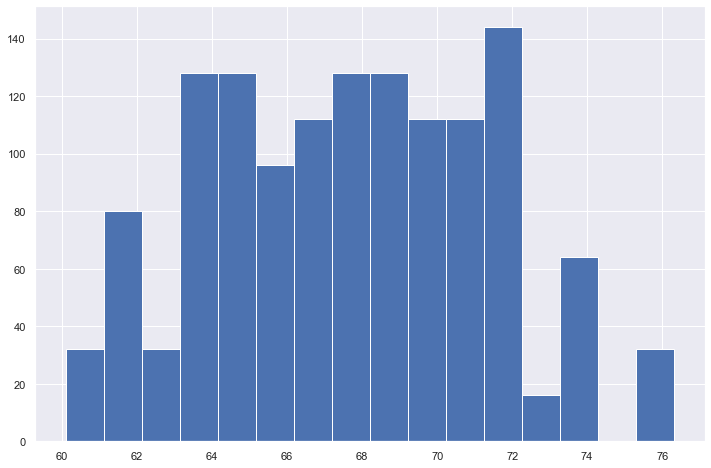

In [64]:
soh = prepSoH(df_soh)
# check sample count distribution for unique values in SoH
plt.hist(soh, bins='auto')

In [65]:
soh.shape

(1344,)

In [66]:
zcs, zc_ds = crossings(df_signal.iloc[0])
len(df_signal.iloc[0])

512

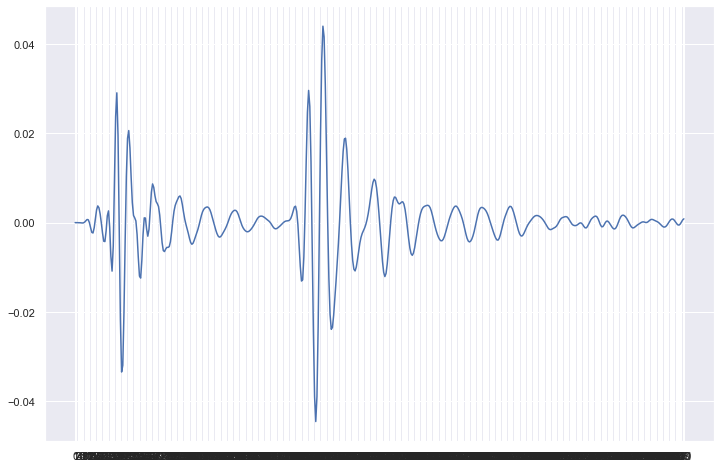

In [67]:
plt.plot(df_signal.iloc[0]) #.015 - check battery, small signal; SOH<55 OR >85 - outside of valid range 

## Data Analysis

### Training

MSE: 0.64728089
Max Error: 5.66909157
Average Error: 0.22014140
R-sq: 0.95212867
[0.28725961 0.05276158 0.18763015 0.10460841 0.10726032 0.13809915
 0.02792496 0.09445582]


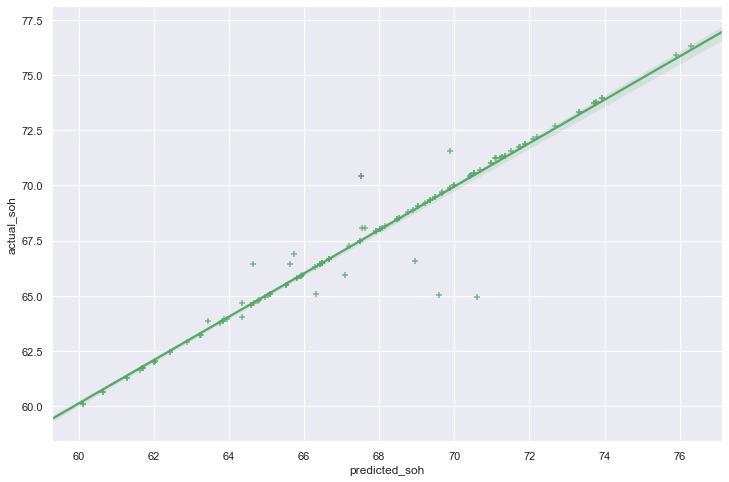

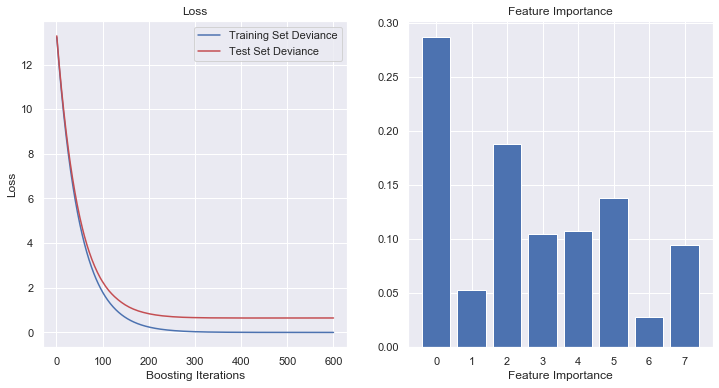

In [68]:
test_result_df = runModel(df_signal, df_soh, 9, True)

Max Error: 0.02765400
MSE in Test set: 0.00008099
Average Error in Test set: 0.00746972916950106
r square value: 0.9999939943454295


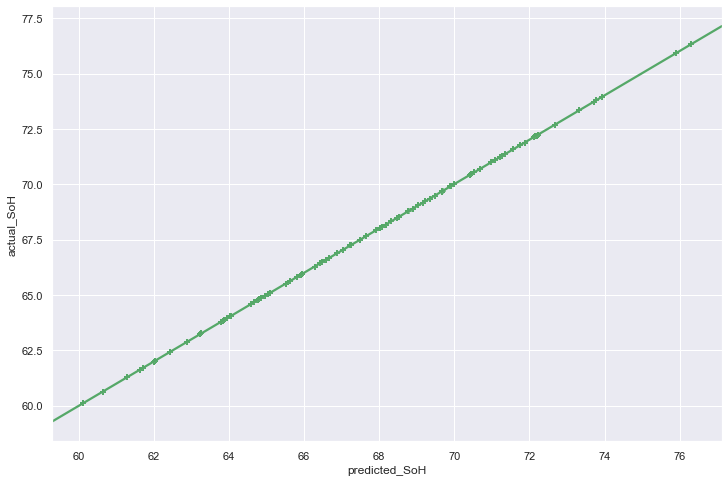

In [69]:
runExportModel(df_signal, df_soh, 9, 'raw.pickle.dat')

### Testing

In [70]:
df_test_1 = pd.read_csv("signal_v1_5.csv")
df_test_2 = pd.read_csv("signal_v2_5.csv")
df_soh_test = pd.read_csv("soh_5.csv")

In [71]:
df_test_1 = df_test_1.iloc[:,2:]
df_test_1.head()
df_test_2.head()
df_soh_test.head()

,ModuleName,Module Number,Number,Accessed Capacity,Unnamed: 4,State of Health
0,TC040,40,43938.2,NaN,66.57303030,NaN
1,TC080,80,44252.7,NaN,67.04954545,NaN
2,TC198,198,42256.6,NaN,64.02515152,NaN
3,TC204,204,44992.3,NaN,68.17015152,NaN
4,TC208,208,43232.4,NaN,65.50363636,NaN


In [72]:
df_test_2 = df_test_2.iloc[:,2:]

In [73]:
df_soh_test = df_soh_test.iloc[:,4]
df_soh_test.head()

0    66.57303030
1    67.04954545
2    64.02515152
3    68.17015152
4    65.50363636
Name: Unnamed: 4, dtype: float64

In [74]:
X_test_1, y_test_1 = processTestData(df_test_1, df_soh_test, 9)

In [75]:
X_test_2, y_test_2 = processTestData(df_test_2, df_soh_test, 9)

Actual:  66.5730303  predicted:  65.20611319963722  diff:  1.3669171003627838
Actual:  67.04954545  predicted:  65.0324735690003  diff:  2.017071880999694
Actual:  64.02515152  predicted:  65.0324735690003  diff:  1.007322049000308
Actual:  68.17015152  predicted:  70.91699137400592  diff:  2.7468398540059127
Actual:  65.50363636  predicted:  65.0324735690003  diff:  0.47116279099969915
Max Error in test set: 2.74683985
Average error in Test set: 1.5218627350736795


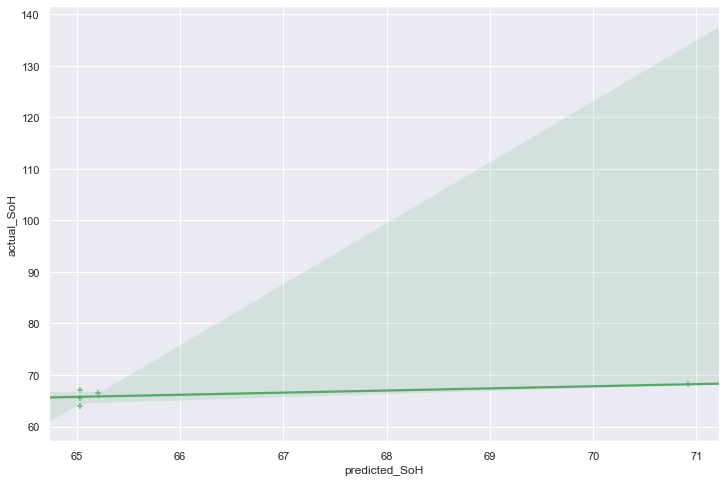

In [76]:
prediction(X_test_1, y_test_1, 'raw.pickle.dat')

Actual:  66.5730303  predicted:  65.0324735690003  diff:  1.5405567309996968
Actual:  67.04954545  predicted:  65.0324735690003  diff:  2.017071880999694
Actual:  64.02515152  predicted:  65.0324735690003  diff:  1.007322049000308
Actual:  68.17015152  predicted:  70.81467256178863  diff:  2.6445210417886216
Actual:  65.50363636  predicted:  65.0324735690003  diff:  0.47116279099969915
Max Error in test set: 2.64452104
Average error in Test set: 1.536126898757604


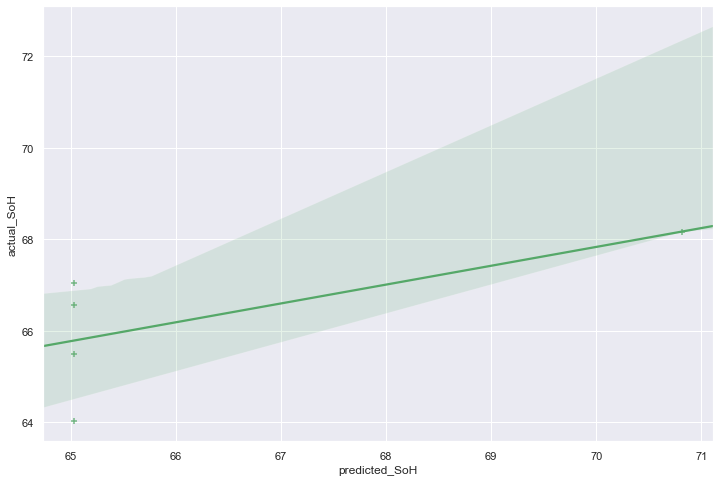

In [77]:
prediction(X_test_2, y_test_2, 'raw.pickle.dat')